In [32]:
import pandas as pd
import numpy as np
import warnings
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
from scipy.stats import beta

In [3]:
demo = pd.read_csv('data/acsreal.csv')
demo.columns = demo.loc[0]
demo = demo.drop(0)
demo['Total'] = np.int64(demo['Estimate!!SEX AND AGE!!Total population']) 
demo['White'] = np.int64(demo['Estimate!!Race alone or in combination with one or more other races!!Total population!!White'])
demo['White %'] = demo['White'] / demo['Total'] * 100
demo = demo[demo['Geographic Area Name'].str.contains('not defined')==False]
demo = demo[demo['Geographic Area Name'].str.contains('Delegate District')==False]
demo = demo[demo['Geographic Area Name'].str.contains('Resident Commissioner') == False]
demo = demo[['Geographic Area Name', 'White %']]
demo = demo.groupby('Geographic Area Name', sort=False).mean().reset_index()
demo
#sns.histplot(demo['White %'])

,Geographic Area Name,White %
0,"Congressional District 1 (116th Congress), Ala...",68.788556
1,"Congressional District 2 (116th Congress), Ala...",65.555585
2,"Congressional District 3 (116th Congress), Ala...",70.661084
3,"Congressional District 4 (116th Congress), Ala...",89.121779
4,"Congressional District 5 (116th Congress), Ala...",77.641286
...,...,...
430,"Congressional District 5 (116th Congress), Wis...",92.371545
431,"Congressional District 6 (116th Congress), Wis...",93.842491
432,"Congressional District 7 (116th Congress), Wis...",94.968650
433,"Congressional District 8 (116th Congress), Wis...",91.702048


In [4]:
kos = pd.read_csv('data/dkos.csv')
states = {
    "AL": "Alabama",
    "AK": "Alaska",
    "AZ": "Arizona",
    "AR": "Arkansas",
    "CA": "California",
    "CO": "Colorado",
    "CT": "Connecticut",
    "DE": "Delaware",
    "FL": "Florida",
    "GA": "Georgia",
    "HI": "Hawaii",
    "ID": "Idaho",
    "IL": "Illinois",
    "IN": "Indiana",
    "IA": "Iowa",
    "KS": "Kansas",
    "KY": "Kentucky",
    "LA": "Louisiana",
    "ME": "Maine",
    "MD": "Maryland",
    "MA": "Massachusetts",
    "MI": "Michigan",
    "MN": "Minnesota",
    "MS": "Mississippi",
    "MO": "Missouri",
    "MT": "Montana",
    "NE": "Nebraska",
    "NV": "Nevada",
    "NH": "New Hampshire",
    "NJ": "New Jersey",
    "NM": "New Mexico",
    "NY": "New York",
    "NC": "North Carolina",
    "ND": "North Dakota",
    "OH": "Ohio",
    "OK": "Oklahoma",
    "OR": "Oregon",
    "PA": "Pennsylvania",
    "RI": "Rhode Island",
    "SC": "South Carolina",
    "SD": "South Dakota",
    "TN": "Tennessee",
    "TX": "Texas",
    "UT": "Utah",
    "VT": "Vermont",
    "VA": "Virginia",
    "WA": "Washington",
    "WV": "West Virginia",
    "WI": "Wisconsin",
    "WY": "Wyoming",
}

kos['District'] = kos['District'].str.replace('-AL', '-at large')
kos[['State', 'No']] = kos['District'].str.split('-', expand=True)
kos['State'] = kos['State'].map(states)
kos['alphaDistrict'] = kos['State']+'-'+kos['No']
kos = kos[['alphaDistrict', 'Trump', 'Total']]
kos['Trump'] = kos['Trump'].str.replace(',','')
kos['Total'] = kos['Total'].str.replace(',','')
kos['Trump%'] = pd.to_numeric(kos['Trump']) / pd.to_numeric(kos['Total']) * 100
kos = kos.sort_values('alphaDistrict', ascending=True)
kos

,alphaDistrict,Trump,Total,Trump%
1,Alabama-01,211370,331886,63.687531
2,Alabama-02,195953,306714,63.887856
3,Alabama-03,212012,324741,65.286490
4,Alabama-04,260535,320725,81.233144
5,Alabama-05,228398,364107,62.728264
...,...,...,...,...
427,Wisconsin-05,255803,450097,56.832860
428,Wisconsin-06,232820,409886,56.801159
429,Wisconsin-07,248822,420340,59.195413
430,Wisconsin-08,241140,421811,57.167784


In [15]:
combined_data = pd.concat([kos,demo], axis=1)
combined_data.head(3)

,alphaDistrict,Trump,Total,Trump%,Geographic Area Name,White %
1,Alabama-01,211370,331886,63.687531,"Congressional District 2 (116th Congress), Ala...",65.555585
2,Alabama-02,195953,306714,63.887856,"Congressional District 3 (116th Congress), Ala...",70.661084
3,Alabama-03,212012,324741,65.286490,"Congressional District 4 (116th Congress), Ala...",89.121779


In [53]:
not_diverse = combined_data[combined_data['White %'] > combined_data['White %'].median()]
diverse = combined_data[combined_data['White %'] <= combined_data['White %'].median()]

53.56124225443038
40.00473263204748


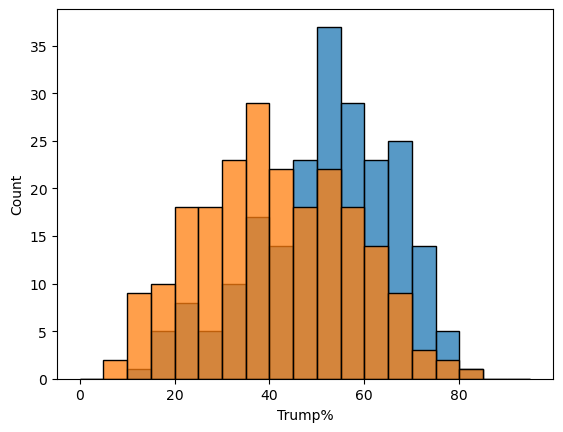

In [55]:
print(not_diverse['Trump%'].median())
sns.histplot(not_diverse['Trump%'], bins = np.arange(0, 100, 5));
print(diverse['Trump%'].median())
sns.histplot(diverse['Trump%'], bins = np.arange(0, 100, 5));

In [56]:
a_nd, b_nd, loc_nd, scale_nd = beta.fit(not_diverse['Trump%'], floc=0, fscale=100)
print(a_nd, b_nd, loc_nd, scale_nd)

a_d, b_d, loc_d, scale_d = beta.fit(diverse['Trump%'], floc=0, fscale=100)
print(a_d, b_d, loc_d, scale_d)

5.705935082541284 5.33223244214401 0 100
3.6359660887087832 5.202948949732078 0 100


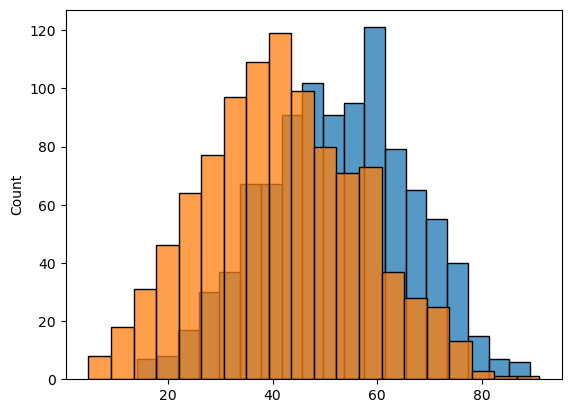

In [60]:
samples_right = beta.rvs(a_nd, b_nd, size=1000) * 100
samples_left = beta.rvs(a_d, b_d, size=1000) * 100

sns.histplot(samples_right)
sns.histplot(samples_left);

In [6]:
N = 435
trump = kos['Trump%']
white = demo['White %'] / 100
m = white.mean()
v = white.var()
a = ((m*m*(1-m))/v)-m
b = (((1-m)*(1-m)*m)/v)-(1-m)
trumpbin = trump>trump.mean()
whitebin = white>white.mean()
mu = np.array([trump[~whitebin].mean(), trump[whitebin].mean()])
sigma = np.array([trump[~whitebin].std(), trump[whitebin].std()])

with pm.Model() as model:
    c = pm.Uniform("c", lower = 0, upper = 1)
    z = pm.Bernoulli("z", p = c, shape = N)
    
    #W = pm.Beta('W', alpha=a, beta=b, observed=white)
    #Wbin = W>np.mean(W)

    mu0 = pm.Beta('mu0', alpha=a_d, beta=b_d, len=435)
    mu1 = pm.Beta('mu1', alpha=a, beta=b, len=435)
    
    thetas = pm.Normal("thetas", mu = mu,
                       sigma = sigma, shape = 2)
    
    Y = pm.Normal("Y", mu = thetas[z], sigma = 15, observed = trump)
    
    trace = pm.sample(1000, chains = 2)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [c, thetas]
>BinaryGibbsMetropolis: [z]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 48 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [1]:
trace

NameError: name 'trace' is not defined

array([[1.        , 0.70044712],
       [0.70044712, 1.        ]])

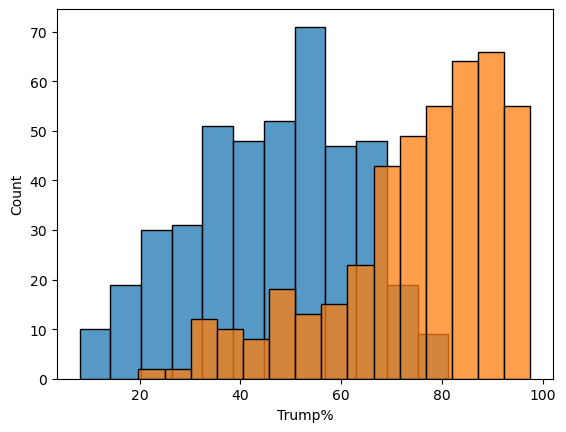

In [6]:
white = demo['White %'] / 100
m = white.mean()
v = white.var()
a = ((m*m*(1-m))/v)-m
b = (((1-m)*(1-m)*m)/v)-(1-m)

trump = kos['Trump%']
white = demo['White %']
sns.histplot(trump)
sns.histplot(white)

np.corrcoef(trump,white)

In [64]:
trumpbin = trump>trump.mean()
whitebin = white>white.mean()

trump[whitebin].mean()

51.60667538270795

In [66]:
trump[~whitebin].mean()

39.20977144848835

In [10]:
demo

,Geographic Area Name,White %
0,"Congressional District 1 (116th Congress), Ala...",68.788556
1,"Congressional District 2 (116th Congress), Ala...",65.555585
2,"Congressional District 3 (116th Congress), Ala...",70.661084
3,"Congressional District 4 (116th Congress), Ala...",89.121779
4,"Congressional District 5 (116th Congress), Ala...",77.641286
...,...,...
430,"Congressional District 5 (116th Congress), Wis...",92.371545
431,"Congressional District 6 (116th Congress), Wis...",93.842491
432,"Congressional District 7 (116th Congress), Wis...",94.968650
433,"Congressional District 8 (116th Congress), Wis...",91.702048
